In [12]:

# PredictThyroid – Model Comparison Notebook

<img src="images/Thyroid.png" alt="Image About Thyroid" width="200" height="300">

- Preprocessing with ColumnTransformer (numeric/categorical)
- Stratified split
- 3 models: Logistic Regression, Random Forest and XGBoost (fallback to Gradient Boosting)
- Metrics (Accuracy, Precision, Recall, F1, ROC-AUC), confusion matrices, ROC curves
- Generates `predictThyroid_model_report.csv`

In [13]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.multiclass import type_of_target

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
    print("XGBoost not available, using GradientBoostingClassifier as fallback.")


XGBoost not available, using GradientBoostingClassifier as fallback.


In [14]:

# Target config and CSV detection
TARGET_NAME = None  # set manually if auto-detection fails

candidate_paths = [
    'predictThyroid.csv',
    'thyroid.csv',
    './datasets/predictThyroid.csv',
    './datasets/thyroid.csv',
    '/mnt/data/predictThyroid.csv',
    '/mnt/data/thyroid.csv'
]

csv_path = None
for p in candidate_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Place the CSV as 'predictThyroid.csv'/'thyroid.csv' in the notebook directory or in /mnt/data/.")

print(f"Using dataset at: {csv_path}")
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
display(df.head())

if TARGET_NAME is None:
    common_targets = ['Outcome','outcome','target','Target','class','Class','label','Label','diagnosis','Diagnosis','y','Y']
    found = [c for c in df.columns if c in common_targets]
    if len(found) >= 1:
        TARGET_NAME = found[0]
        print("Auto-detected target:", TARGET_NAME)
    else:
        # Heuristic fallback: prefer small-cardinality columns (2..10 unique)
        candidates = []
        for c in df.columns:
            try:
                nuniq = df[c].nunique(dropna=True)
            except Exception:
                continue
            if 2 <= nuniq <= 10:
                candidates.append((c, nuniq))
        if candidates:
            candidates.sort(key=lambda x: x[1])
            TARGET_NAME = candidates[0][0]
            print("Heuristic target (small cardinality):", TARGET_NAME)
        else:
            TARGET_NAME = df.columns[-1]
            print("Fallback target (last column):", TARGET_NAME)


Using dataset at: ./datasets/thyroid.csv
Shape: (383, 17)


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


Heuristic target (small cardinality): Gender


In [15]:

y = df[TARGET_NAME]
X = df.drop(columns=[TARGET_NAME])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric:", num_cols[:12])
print("Categorical:", cat_cols[:12])

ttype = type_of_target(y)
strat = y if ttype in ("binary","multiclass") else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)
X_train.shape, X_test.shape, ttype


Numeric: ['Age']
Categorical: ['Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology', 'Focality', 'Risk', 'T', 'N', 'M']


((306, 16), (77, 16), 'binary')

In [16]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=True))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocess = ColumnTransformer(
    transformers=[('num', numeric_transformer, num_cols),
                  ('cat', categorical_transformer, cat_cols)],
    remainder='drop'
)
preprocess


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [17]:

models = {}
models['Logistic Regression'] = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(random_state=42, max_iter=2000, multi_class='ovr'))
])
models['Random Forest'] = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])
if XGB_AVAILABLE:
    models['XGBoost'] = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', XGBClassifier(random_state=42, n_estimators=500, learning_rate=0.05,
                              max_depth=4, subsample=0.9, colsample_bytree=0.9,
                              reg_lambda=1.0, eval_metric='mlogloss', tree_method='hist',
                              use_label_encoder=False, n_jobs=-1))
    ])
else:
    models['Gradient Boosting (fallback)'] = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', GradientBoostingClassifier(random_state=42))
    ])
list(models.keys())


['Logistic Regression', 'Random Forest', 'Gradient Boosting (fallback)']

In [18]:

def compute_metrics(y_true, y_pred, y_proba=None, average='weighted'):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1   = f1_score(y_true, y_pred, average=average, zero_division=0)
    auc_val = np.nan
    ttype = type_of_target(y_true)
    if y_proba is not None:
        try:
            if ttype == 'binary':
                if y_proba.ndim == 2 and y_proba.shape[1] > 1:
                    proba_pos = y_proba[:, 1]
                else:
                    proba_pos = y_proba.ravel()
                auc_val = roc_auc_score(y_true, proba_pos)
            elif ttype == 'multiclass':
                auc_val = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
        except Exception:
            pass
    return acc, prec, rec, f1, auc_val

# Ranking de modelos (ajuste a ordem conforme sua preferência)
# Por padrão: F1 > Accuracy > ROC-AUC (weighted)
RANK_ORDER = ['f1', 'accuracy', 'roc_auc_weighted']


results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    y_proba = None
    clf = pipe.named_steps['clf']
    try:
        if hasattr(clf, "predict_proba"):
            y_proba = pipe.predict_proba(X_test)
        elif hasattr(clf, "decision_function"):
            from sklearn.preprocessing import MinMaxScaler
            s = pipe.decision_function(X_test)
            if s.ndim == 1:
                s = s.reshape(-1, 1)
            y_proba = MinMaxScaler().fit_transform(s)
    except Exception:
        y_proba = None

    acc, prec, rec, f1, auc_val = compute_metrics(y_test, y_pred, y_proba, average='weighted')
    results.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc_weighted': auc_val})

results_df = pd.DataFrame(results).sort_values(by=RANK_ORDER, ascending=False).reset_index(drop=True)
# Add a column marking the top row (best model)
if len(results_df) > 0:
    best_flags = [''] * len(results_df)
    best_flags[0] = '*'
    results_df.insert(0, 'best', best_flags)
results_df


c:\Users\romil\anaconda3\envs\envproj2\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


,best,model,accuracy,precision,recall,f1,roc_auc_weighted
0,*,Logistic Regression,0.831169,0.810903,0.831169,0.816040,0.802721
1,,Gradient Boosting (fallback),0.805195,0.810655,0.805195,0.807774,0.770408
2,,Random Forest,0.805195,0.799825,0.805195,0.802354,0.804422


In [19]:

for name, pipe in models.items():
    print("="*70)
    print(name)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))


Logistic Regression
              precision    recall  f1-score   support

           F     0.8676    0.9365    0.9008        63
           M     0.5556    0.3571    0.4348        14

    accuracy                         0.8312        77
   macro avg     0.7116    0.6468    0.6678        77
weighted avg     0.8109    0.8312    0.8160        77

Random Forest
              precision    recall  f1-score   support

           F     0.8750    0.8889    0.8819        63
           M     0.4615    0.4286    0.4444        14

    accuracy                         0.8052        77
   macro avg     0.6683    0.6587    0.6632        77
weighted avg     0.7998    0.8052    0.8024        77

Gradient Boosting (fallback)
              precision    recall  f1-score   support

           F     0.8871    0.8730    0.8800        63
           M     0.4667    0.5000    0.4828        14

    accuracy                         0.8052        77
   macro avg     0.6769    0.6865    0.6814        77
weighted av

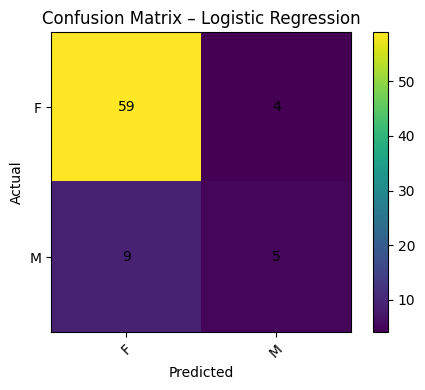

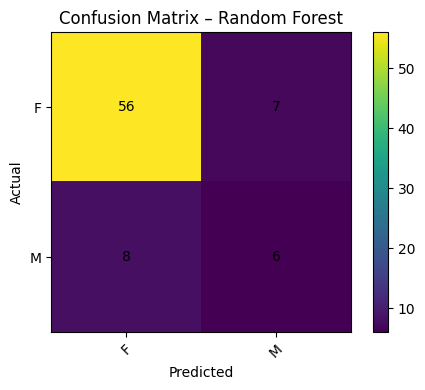

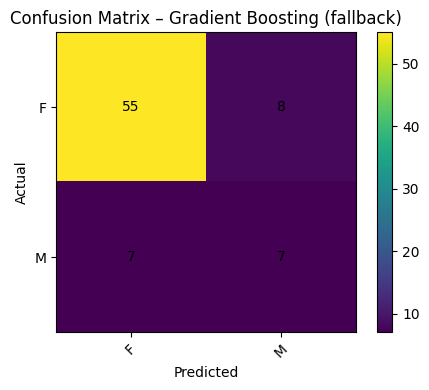

In [20]:

labels = np.unique(y_test)
for name, pipe in models.items():
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    plt.yticks(ticks=range(len(labels)), labels=labels)
    plt.colorbar(); plt.tight_layout(); plt.show()


C:\Users\romil\AppData\Local\Temp\ipykernel_29164\3153746508.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.tight_layout(); plt.show()


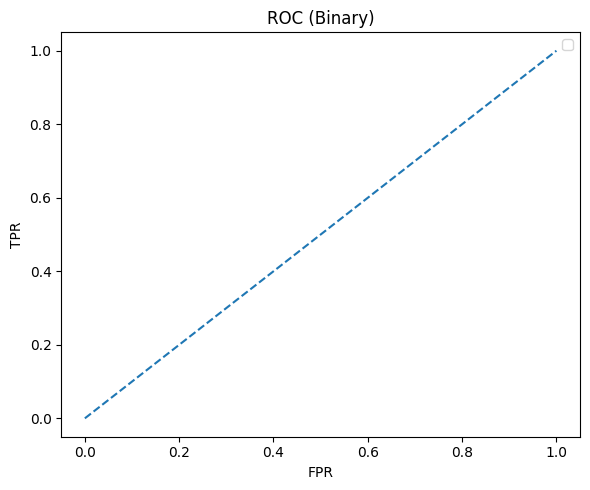

In [21]:

from sklearn.preprocessing import label_binarize

ttype = type_of_target(y_test)
if ttype == 'binary':
    plt.figure(figsize=(6,5))
    for name, pipe in models.items():
        try:
            if hasattr(pipe.named_steps['clf'], "predict_proba"):
                y_proba = pipe.predict_proba(X_test)[:, 1]
            elif hasattr(pipe.named_steps['clf'], "decision_function"):
                from sklearn.preprocessing import MinMaxScaler
                s = pipe.decision_function(X_test).reshape(-1,1)
                y_proba = MinMaxScaler().fit_transform(s).ravel()
            else:
                y_proba = None
            if y_proba is None:
                continue
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=name)
        except Exception:
            continue
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Binary)")
    plt.legend(); plt.tight_layout(); plt.show()
elif ttype == 'multiclass':
    classes = np.unique(y_test)
    for name, pipe in models.items():
        try:
            if hasattr(pipe.named_steps['clf'], "predict_proba"):
                y_proba = pipe.predict_proba(X_test)
            elif hasattr(pipe.named_steps['clf'], "decision_function"):
                from sklearn.preprocessing import MinMaxScaler
                s = pipe.decision_function(X_test)
                if s.ndim == 1: s = s.reshape(-1,1)
                y_proba = MinMaxScaler().fit_transform(s)
            else:
                y_proba = None
            if y_proba is None:
                continue
            y_bin = label_binarize(y_test, classes=classes)
            plt.figure(figsize=(6,5))
            for i, cls in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
                plt.plot(fpr, tpr, label=f"Class {cls}")
            plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR")
            plt.title(f"ROC (OVR) – {name}"); plt.legend(); plt.tight_layout(); plt.show()
        except Exception:
            continue


In [22]:

out_csv = "outputs/predictThyroid_model_report.csv"
results_df.to_csv(out_csv, index=False)
print(f"Report saved to: {out_csv}")
results_df


Report saved to: outputs/predictThyroid_model_report.csv


,best,model,accuracy,precision,recall,f1,roc_auc_weighted
0,*,Logistic Regression,0.831169,0.810903,0.831169,0.816040,0.802721
1,,Gradient Boosting (fallback),0.805195,0.810655,0.805195,0.807774,0.770408
2,,Random Forest,0.805195,0.799825,0.805195,0.802354,0.804422
